In [1]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, res_capacity_atlite, region_plotting
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")
#warnings.filterwarnings("ignore", category=UserWArning, message="warnings.filterwarnings("ignore", category=FutureWarning, message="

In [2]:
# SYNTHETIC -> excludes Europe and USA
path = "/Volumes/fi246disk/synde/resources/gegis/output"
load_profile_dic = {}
for key, value in regions_dic.items():
    load_profile_dic[key] = {}
    if key != "north_america" and key != "europe" and key != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" )

# HISTORIC -> includes Europe and USA
demand_mult_ssp1_26_oecd = 1.36
load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
synthetic_load_north_america_no_usa = syntheticdemand_gis(path, "north_america_no_usa", "ssp1-26")
load_profile_dic["north_america"]["load"] = historic_load_usa + synthetic_load_north_america_no_usa

res_potential_dic = {}
for key, value in regions_dic.items():
    #if key != "oceania": #and key != "south_asia" and key != "middle_east" and key != "europe" and key != "north_africa":
    res_potential_dic[key] = {}
    res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=5, land_available=0.08)
    res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05)
        

Calculating wind for north_america
Calculating pv for north_america
Calculating wind for latin_america
Calculating pv for latin_america
Calculating wind for oceania
Calculating pv for oceania
Calculating wind for north_asia
Calculating pv for north_asia
Calculating wind for south_asia
Calculating pv for south_asia
Calculating wind for north_west_asia
Calculating pv for north_west_asia
Calculating wind for south_west_asia
Calculating pv for south_west_asia
Calculating wind for middle_east
Calculating pv for middle_east
Calculating wind for europe
Calculating pv for europe
Calculating wind for ups
Calculating pv for ups
Calculating wind for north_africa
Calculating pv for north_africa
Calculating wind for africa
Calculating pv for africa
Calculating wind for atlantic_north
Calculating pv for atlantic_north


In [3]:
# Define the snapshots
snapshots = pd.date_range("2050-01-01", periods=3, freq="h")
# Renewable energy potential time series
# res_potential_node1 = pd.Series([2, 8, 4, 2, 8, 4], index=snapshots)
# res_potential_node2 = pd.Series([2, 2, 2, 2, 8, 4], index=snapshots)
# res_potential_node1_PV = pd.Series([1, 3, 1, 5, 2, 3], index=snapshots)
# res_potential_node2_PV = pd.Series([0, 3, 4, 6, 8, 3], index=snapshots)
res_potential_node1 = res_potential_dic['north_america']['wind'][snapshots]
res_potential_node2 = res_potential_dic['europe']['wind'][snapshots]
res_potential_node3 = res_potential_dic['north_africa']['wind'][snapshots]
# Demand time series
# demand_node1 = pd.Series([2, 4, 2, 1, 1, 1], index=snapshots)
# demand_node2 = pd.Series([1, 1, 1, 1, 1, 1], index=snapshots)
demand_node1 = load_profile_dic['north_america']['load'][snapshots]
demand_node2 = load_profile_dic['europe']['load'][snapshots]
demand_node3 = load_profile_dic['north_africa']['load'][snapshots]
print('Surpplus: ',demand_node1 - res_potential_node1, demand_node2 - res_potential_node2, demand_node3 -res_potential_node3)

Surpplus:  2050-01-01 00:00:00   -4.753615e+06
2050-01-01 01:00:00   -5.098593e+06
2050-01-01 02:00:00   -5.273372e+06
dtype: float64 2050-01-01 00:00:00   -2.439115e+06
2050-01-01 01:00:00   -2.412076e+06
2050-01-01 02:00:00   -2.411960e+06
dtype: float64 2050-01-01 00:00:00   -1.185666e+06
2050-01-01 01:00:00   -1.188366e+06
2050-01-01 02:00:00   -1.187514e+06
Freq: h, dtype: float64


In [7]:
# Create a new network
n = pypsa.Network()


n.set_snapshots(snapshots)

# Add buses
n.add("Bus", "node1", v_nom=800,  v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)
n.add("Bus", "node2",  v_nom=800,v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)
n.add("Bus", "node3",  v_nom=800,v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)
n.add("Bus", "node4", v_nom=800, v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)




# Add renewable generators with fixed production according to potential
# n.add("Generator", "res_node1", bus="node1", type="Wind", p_nom_extendable=False, p_set=res_potential_node1,marginal_cost=200, capital_cost=1000)
# n.add("Generator", "res_node2", bus="node2", type="Wind", p_nom_extendable=False,p_set=res_potential_node2,marginal_cost=200, capital_cost=1000)
# n.add("Generator", "res_node3", bus="node3", type="Wind", p_nom_extendable=False,p_set=res_potential_node3,marginal_cost=200, capital_cost=1000)
n.add("Generator", "res_node1", bus="node1", carrier="Wind", p_nom_extendable=True, p_nom_max = 100, p_max_pu=res_potential_node1, p_min_pu=res_potential_node1,marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node2", bus="node2", carrier="Wind", p_nom_extendable=True,p_nom_max = 100, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2,marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node3", bus="node3", carrier="Wind", p_nom_extendable=True,p_nom_max = 100, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2,marginal_cost=2, capital_cost=2)
# n.add("Generator", "res_node1", bus="node1", type="Wind", p_nom_extendable=True, marginal_cost=200, capital_cost=1000)
# n.add("Generator", "res_node2", bus="node2", type="Wind", p_nom_extendable=True,marginal_cost=200, capital_cost=1000)
# n.add("Generator", "res_node3", bus="node3", type="Wind", p_nom_extendable=True,marginal_cost=200, capital_cost=1000)
n.add("Generator", "slack", bus="node4", type= 'Slack', p_nom_extendable=True, p_nom_max = 1e10,marginal_cost=100000, sign=-1)

#n.add("Generator", "res_node3", bus="node3", carrier="Wind", p_nom_extendable=True,p_nom_max = 1, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2,marginal_cost=2, capital_cost=2)
#n.add("Generator", "curtailment", bus="node3", carrier="Gas", p_nom = 1, p_nom_extendable=True, marginal_cost=1)
# n.add("Generator", "res_node1_pv", bus="node1", carrier="PV", p_nom_extendable=True, p_max_pu=res_potential_node1_PV, p_min_pu=res_potential_node1_PV, marginal_cost=1)
# n.add("Generator", "res_node2_pv", bus="node2", carrier="PV", p_nom_extendable=True, p_max_pu=res_potential_node2_PV, p_min_pu=res_potential_node2_PV, marginal_cost=1)

# Add loads
n.add("Load", "load_node1", bus="node1", p_set=demand_node1)
n.add("Load", "load_node2", bus="node2", p_set=demand_node2)
n.add("Load", "load_node3", bus="node3", p_set=demand_node3)
n.add("Load", "load_node4", bus="node4", p_set=np.zeros(len(snapshots)))
#n.add("Load", "load_node3", bus="node3", p_set=demand_node2)

# Add a transmission line (link) between the nodes
n.add("Link", "link_node1_node2", bus0="node1", bus1="node2", p_nom_extendable=True, p_min_pu=-1, efficiency=0.9, marginal_cost=200)
n.add("Link", "link_node1_node3", bus0="node1", bus1="node3", p_nom_extendable=True, p_min_pu=-1, efficiency=0.9, marginal_cost=200)
n.add("Link", "link_node3_node2", bus0="node2", bus1="node3", p_nom_extendable=True, p_min_pu=-1, efficiency=0.9, marginal_cost=200)
n.add("Link", "link_slack3", bus0="node4", bus1="node3", p_nom_extendable=True, p_min_pu=-1, efficiency=1.0, marginal_cost=2000000)
n.add("Link", "link_slack2", bus0="node4", bus1="node2", p_nom_extendable=True,p_min_pu=-1, efficiency=1.0, marginal_cost=200000)
n.add("Link", "link_slack1", bus0="node4", bus1="node1", p_nom_extendable=True,  p_min_pu=-1, efficiency=1.0, marginal_cost=200000)
# n.add("Link", "link_curtailment_node2", bus0="node3", bus1="node2", p_nom_extendable=True, p_min_pu=-1, efficiency=0.7)
# n.add("Link", "link_curtailment_node1", bus0="node3", bus1="node1", p_nom_extendable=True, p_min_pu=-1, efficiency=0.7)


# Add curtailment generators with high marginal cost to penalize excess generation
curtailment_cost = 1000  # High cost to penalize curtailment
# n.add("Generator", "curtailment_node1", bus="node1", type='Curtailment',p_nom_extendable=True, p_nom_max = 1e10,marginal_cost=curtailment_cost, sign=-1)
# n.add("Generator", "curtailment_node2", bus="node2", type= 'Curtailment',p_nom_extendable=True, p_nom_max = 1e10,marginal_cost=curtailment_cost, sign=-1)
# n.add("Generator", "curtailment_node3", bus="node3", type= 'Curtailment', p_nom_extendable=True, p_nom_max = 1e10,marginal_cost=curtailment_cost, sign=-1)
# Check if all buses exist
# print(n.buses)



m = n.optimize.create_model();

# Access the generator power output variable
# gen_p = m.variables["Generator-p"]
# total_generation = gen_p.sum().sum()
# total_demand = n.loads_t.p_set.sum().sum()
# constraint_expression = total_generation == total_demand
# m.add_constraints(constraint_expression, name="generation_meets_demand")

n.optimize(solver_name='highs')

# Print the results
print(n.generators.p_nom_opt)
print(n.generators_t.p)
print(n.loads_t)
print(n.links_t.p0)
print(n.links_t.p1)


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/highs.log
Status: warning
Termination condition: unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: unbounded



Running HiGHS 1.7.1 (git hash: 0c240d8): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 6e+06]
  Cost   [2e+00, 2e+06]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+10]
Presolving model
30 rows, 33 cols, 84 nonzeros  0s
18 rows, 21 cols, 36 nonzeros  0s
Solving the original LP with primal simplex to determine infeasible or unbounded
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 9(339285); Du: 27(16.95) 0s
         64    -5.5243957874e+16 Pr: 0(0); Du: 9(2.9816e+07) 0s
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
         64    -5.5243972521e+16 Pr: 0(0); Du: 8(1.4908e+07) 0s
         65    -5.5260898310e+16 Pr: 0(0); Du: 7(1.10281e+07) 0s
Model   status      : Unbounded
Simplex   iterations: 65
Objective value     : -5.5260898310e+16
HiGHS run time      :          0.00
Generator
res_node1    0.0
res_node2    0.0
res_node3   

In [119]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa


# Create a new network
n = pypsa.Network()

# Define the snapshots
snapshots = pd.date_range("2023-01-01", periods=3, freq="h")
n.set_snapshots(snapshots)

# Add buses
n.add("Bus", "node1", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95, v_mag_pu_max=1.05)
n.add("Bus", "node2", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95, v_mag_pu_max=1.05)
#n.add("Bus", "node3", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)
# n.add("Bus", "node3", v_nom=1.0, v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05)


# Renewable energy potential time series
# res_potential_node1 = pd.Series([2, 8, 4, 2, 8, 4], index=snapshots)
# res_potential_node2 = pd.Series([2, 2, 2, 2, 8, 4], index=snapshots)
# res_potential_node1_PV = pd.Series([1, 3, 1, 5, 2, 3], index=snapshots)
# res_potential_node2_PV = pd.Series([0, 3, 4, 6, 8, 3], index=snapshots)
res_potential_node1 = pd.Series([2, 8, 4], index=snapshots)
res_potential_node2 = pd.Series([2, 2, 2], index=snapshots)

# Demand time series
# demand_node1 = pd.Series([2, 4, 2, 1, 1, 1], index=snapshots)
# demand_node2 = pd.Series([1, 1, 1, 1, 1, 1], index=snapshots)
demand_node1 = pd.Series([2, 4, 2], index=snapshots)
demand_node2 = pd.Series([1, 1, 1], index=snapshots)


# Add renewable generators with fixed production according to potential
n.add("Generator", "res_node1", bus="node1", type="Wind", p_nom_extendable=False, p_nom = 1, p_max_pu=res_potential_node1, p_min_pu=res_potential_node1,marginal_cost=2, capital_cost=2)
n.add("Generator", "res_node2", bus="node2", type="Wind", p_nom_extendable=False,p_nom = 1, p_max_pu=res_potential_node2, p_min_pu=res_potential_node2, marginal_cost=2, capital_cost=2)

# Add loads
n.add("Load", "load_node1", bus="node1", p_set=demand_node1)
n.add("Load", "load_node2", bus="node2", p_set=demand_node2)
#n.add("Load", "load_node3", bus="node3", p_set=demand_node1)

# Add a transmission line (link) between the nodes
n.add("Link", "link_node1_node2", bus0="node1", bus1="node2", p_nom_extendable=True, p_min_pu=-1, efficiency=0.9, marginal_cost = 1)

# Add curtailment generators with high marginal cost to penalize excess generation
curtailment_cost = 0  # High cost to penalize curtailment
n.add("Generator", "curtailment_node1", bus="node1", type='Curtailment', p_nom_extendable=True,marginal_cost=curtailment_cost, sign=-1)
n.add("Generator", "curtailment_node2", bus="node2", type='Curtailment', p_nom_extendable=True, marginal_cost=curtailment_cost, sign=-1)
# n.add("Store", "curtailment_node1", bus="node1", type='Curtailment', e_nom_extendable=True,marginal_cost=curtailment_cost)
# n.add("Store", "curtailment_node2", bus="node2", type='Curtailment', e_nom_extendable=True, marginal_cost=curtailment_cost)

m = n.optimize.create_model();


n.optimize(solver_name='gurobi')

# Print the results
print(n.generators.p_nom_opt)
print(n.generators_t.p)
print(n.loads_t.p_set)
print(n.links_t.p0)
print(n.links_t.p1)


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io: Writing time: 0.02s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uinxsg3f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uinxsg3f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 39 rows, 18 columns, 63 nonzeros


INFO:gurobipy:obj: 39 rows, 18 columns, 63 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 39 rows, 18 columns and 63 nonzeros


INFO:gurobipy:Optimize a model with 39 rows, 18 columns and 63 nonzeros


Model fingerprint: 0x4ae562f4


INFO:gurobipy:Model fingerprint: 0x4ae562f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e+00, 2e+00]


INFO:gurobipy:  Objective range  [1e+00, 2e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 8e+00]


INFO:gurobipy:  RHS range        [1e+00, 8e+00]


Presolve removed 39 rows and 18 columns


INFO:gurobipy:Presolve removed 39 rows and 18 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.6666667e+01   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       0    3.6666667e+01   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 0 iterations and 0.00 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.00 seconds (0.00 work units)


Optimal objective  3.666666667e+01


INFO:gurobipy:Optimal objective  3.666666667e+01
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 18 primals, 39 duals
Objective: 3.67e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


Generator
res_node1            1.000000
res_node2            1.000000
curtailment_node1    5.111111
curtailment_node2    0.000000
Name: p_nom_opt, dtype: float64
Generator            res_node1  res_node2  curtailment_node1  \
snapshot                                                       
2023-01-01 00:00:00        2.0        2.0           1.111111   
2023-01-01 01:00:00        8.0        2.0           5.111111   
2023-01-01 02:00:00        4.0        2.0           3.111111   

Generator            curtailment_node2  
snapshot                                
2023-01-01 00:00:00                0.0  
2023-01-01 01:00:00                0.0  
2023-01-01 02:00:00                0.0  
Load                 load_node1  load_node2
snapshot                                   
2023-01-01 00:00:00         2.0         1.0
2023-01-01 01:00:00         4.0         1.0
2023-01-01 02:00:00         2.0         1.0
Link                 link_node1_node2
snapshot                             
2023-01-01 00:00

In [29]:
m.constraints['generation_meets_demand']

Constraint `generation_meets_demand`
------------------------------------
+1 Generator-p[2050-01-01 00:00:00, res_node1] + 1 Generator-p[2050-01-01 00:00:00, res_node2] + 1 Generator-p[2050-01-01 00:00:00, res_node3] ... +1 Generator-p[2050-01-01 02:00:00, curtailment_node1] + 1 Generator-p[2050-01-01 02:00:00, curtailment_node2] + 1 Generator-p[2050-01-01 02:00:00, curtailment_node3] = 2714278.695527597

In [107]:
# THIS WORKS, NEXT STEP IS TO PLOT IT
balances = []
outflows = []
generations = []
loads = []
slacks = []
curtailments = []
for snapshot in snapshots:
    buses = []
    balances_ = []
    outflows_ = []
    generations_ = []
    curtailments_ = []
    loads_ = []
    for bus in n.buses.index:
        vre_generators = n.generators[(n.generators['bus'] == bus) & ((n.generators['type'] == "Wind") | (n.generators['type'] == "PV"))]
        cur_generators = n.generators[(n.generators['bus'] == bus) & (n.generators['type'] == "Curtailment")]
        vre_p = n.generators_t.p.loc[snapshot, vre_generators.index].sum()
        cur_p = n.generators_t.p.loc[snapshot, cur_generators.index].sum()
        outflow = 0
        load = n.loads_t.p_set.loc[snapshot][f'load_{bus}']
        for link in n.links.index:
            if bus == n.links["bus0"][link]:
                outflow += n.links_t.p0.loc[snapshot][link]
            if bus == n.links["bus1"][link]:
                outflow += n.links_t.p1.loc[snapshot][link]
        balance = vre_p - load - cur_p -outflow
        balances_.append(balance)
        outflows_.append(outflow)
        generations_.append(vre_p)
        curtailments_.append(cur_p)
        loads_.append(load)
    balances.append(balances_)
    outflows.append(outflows_)
    generations.append(generations_)
    curtailments.append(curtailments_)
    loads.append(loads_)

In [108]:
# Convert lists to numpy arrays for easier indexing
balances = np.array(balances)
outflows = np.array(outflows) * -1   # Make outflows negative
generations = np.array(generations)
curtailments = np.array(curtailments)
loads = np.array(loads)
total_balance = np.sum(generations) - np.sum(curtailments)- np.sum(loads)
print(generations)
print(loads)
print(total_balance)

[[2. 2.]
 [8. 2.]
 [4. 2.]]
[[2. 1.]
 [4. 1.]
 [2. 1.]]
0.0


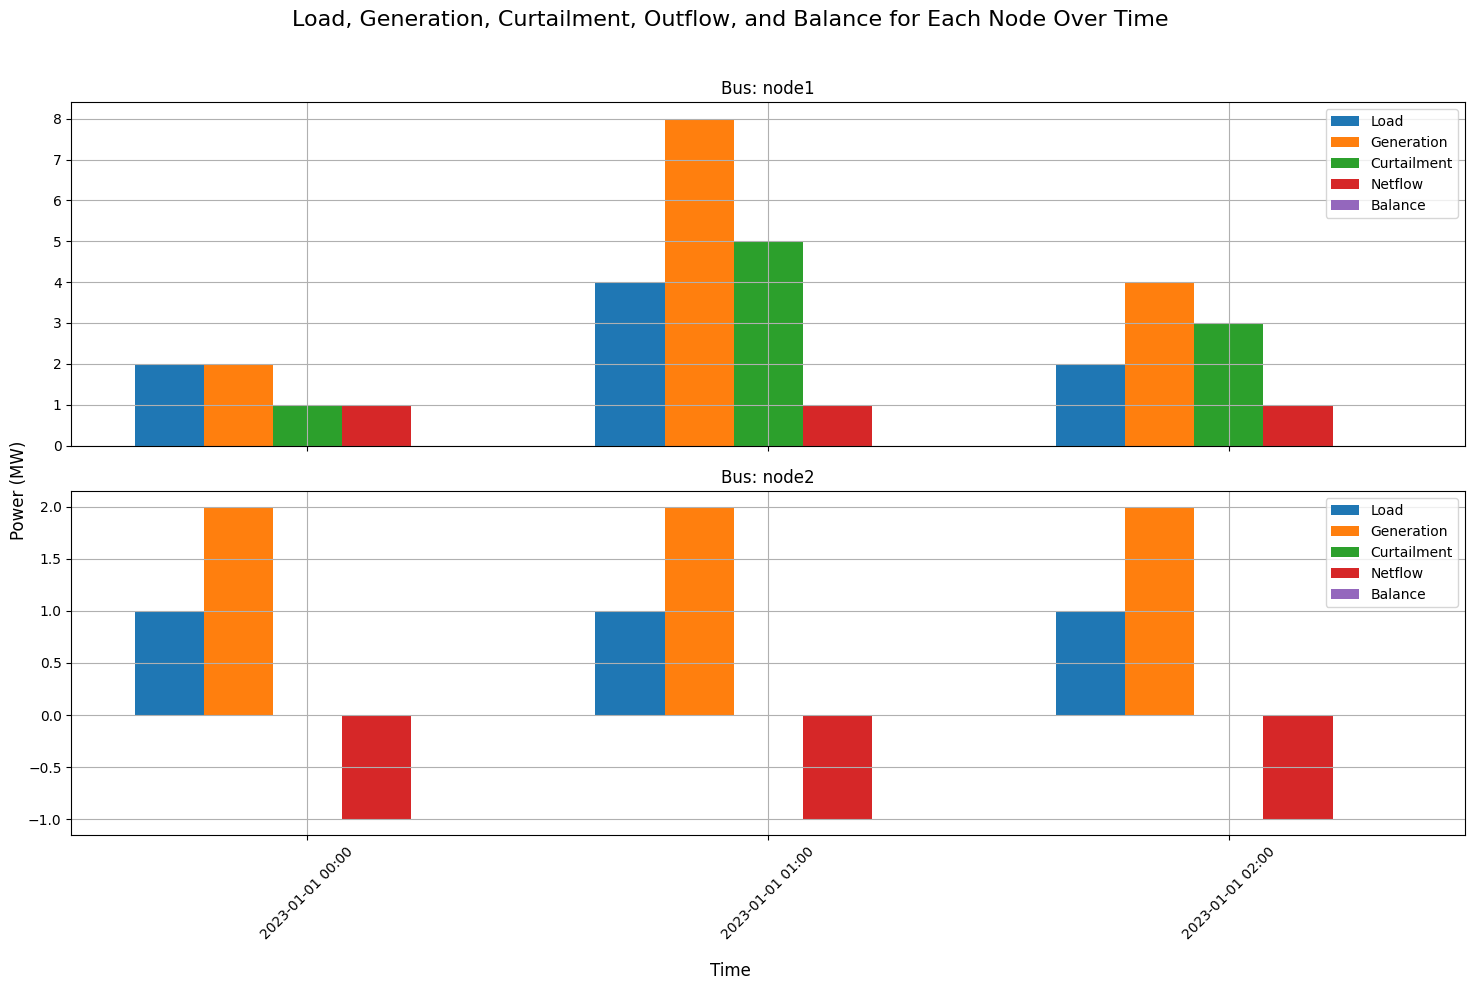

In [109]:
# Ensure all sublists have the same length
num_buses = len(n.buses.index)

# Number of snapshots
num_snapshots = len(snapshots)

# Create subplots for each bus
fig, axes = plt.subplots(num_buses, 1, figsize=(15, num_buses * 5), sharex=True)

# If there's only one bus, make sure axes is iterable
if num_buses == 1:
    axes = [axes]

# Plot data for each bus
bar_width = 0.15  # Adjust bar width to fit all bars within each time step
for i, bus in enumerate(n.buses.index):
    ax = axes[i]
    indices = np.arange(num_snapshots)
    
    # Plot load
    ax.bar(indices - 2 * bar_width, loads[:, i], bar_width, label='Load')
    
    # Plot generation
    ax.bar(indices - bar_width, generations[:, i], bar_width, label='Generation')

    # Plot curtailment
    ax.bar(indices, curtailments[:, i], bar_width, label='Curtailment')
    
    # Plot outflow
    ax.bar(indices + bar_width, outflows[:, i], bar_width, label='Netflow')
    
    # Plot balance
    ax.bar(indices + 2 * bar_width, balances[:, i], bar_width, label='Balance')
    
    ax.set_title(f"Bus: {bus}")
    ax.set_xticks(indices)
    ax.set_xticklabels(snapshots.strftime('%Y-%m-%d %H:%M'), rotation=45)
    ax.legend()
    ax.grid(True)

# Set overall plot title and labels
fig.suptitle('Load, Generation, Curtailment, Outflow, and Balance for Each Node Over Time', fontsize=16)
fig.supxlabel('Time')
fig.supylabel('Power (MW)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1]:
print('test')

test
